<a href="https://colab.research.google.com/github/nurmayadi/learn-machine-learning/blob/main/imageclassification_animals10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dicoding Submission

##Fitra Nurmayadi

Proyek ini adalah untuk mengklasifikasikan jenis hewan, dan menjadikan model ML ke TFLite untuk dapat dipakai pada implementasi di mobile.

Kaggle preparation

In [ ]:
!pip install -q kaggle

In [ ]:
import json
dictionary = {"username":"fitranurmayadi","key":"41904ce5805c3bb261bff4ae8d16a6b0"}
json_object = json.dumps(dictionary, indent=4)
with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Import Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#Data Acquisition

menggunakan data animals10 dari kaggle

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

 98% 572M/586M [00:02<00:00, 281MB/s]
100% 586M/586M [00:02<00:00, 214MB/s]


In [ ]:
!unzip -q animals10.zip -d "animals10"

In [ ]:
base_dir = "/content/animals10/raw-img"

In [ ]:
print(os.listdir(base_dir))

['pecora', 'gatto', 'cane', 'gallina', 'elefante', 'farfalla', 'ragno', 'cavallo', 'scoiattolo', 'mucca']


Rename Folder

In [ ]:
from pathlib import Path
import shutil


folder_names = os.listdir(base_dir)

def rename_folder(current_name: str,
                  new_name: str,
                  path: Path) -> None:
    os.rename(os.path.join(path, current_name), os.path.join(path, new_name))

for folder in folder_names:
    current_folder = base_dir

    try:
        if folder == "cane":
            rename_folder(folder, "dog", current_folder)
        elif folder == "cavallo":
            rename_folder(folder, "horse", current_folder)
        elif folder == "elefante":
            rename_folder(folder, "elephant", current_folder)
        elif folder == "farfalla":
            rename_folder(folder, "butterfly", current_folder)
        elif folder == "gallina":
            rename_folder(folder, "chicken", current_folder)
        elif folder == "gatto":
            rename_folder(folder, "cat", current_folder)
        elif folder == "mucca":
            rename_folder(folder, "cow", current_folder)
        elif folder == "pecora":
            rename_folder(folder, "sheep", current_folder)
        elif folder == "ragno":
            rename_folder(folder, "spider", current_folder)
        elif folder == "scoiattolo":
            rename_folder(folder, "squirrel", current_folder)
    except Exception:
        shutil.rmtree(current_folder +"/"+ folder)
print("Folders renamed.")

Folders renamed.


In [ ]:
print(os.listdir(base_dir))

['cat', 'butterfly', 'spider', 'cow', 'horse', 'dog', 'squirrel', 'elephant', 'sheep', 'chicken']


#Data Understanding

Cek jumlah gambar

In [ ]:
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 26179


Cek persebaran jumlah gambar setiap kelas data

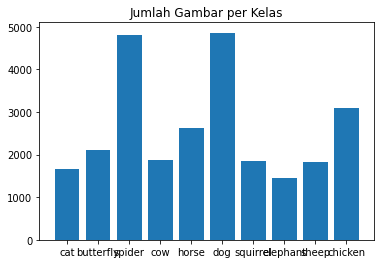

In [ ]:
plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar per Kelas");

Tampilkan sampel gambar untuk mengetahui ukurannya

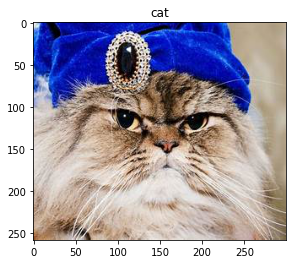

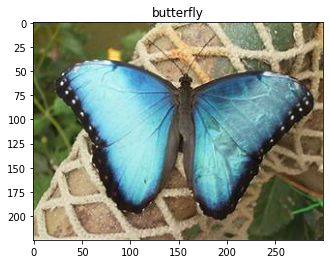

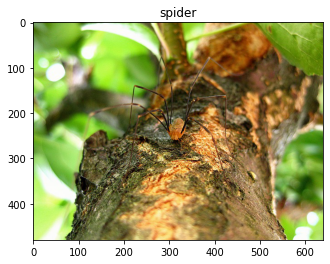

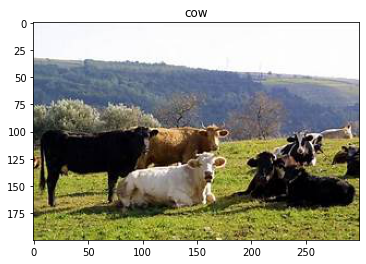

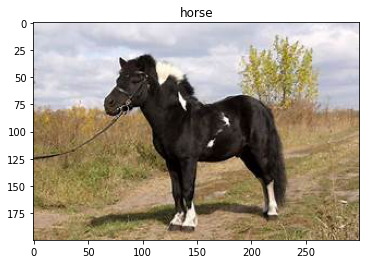

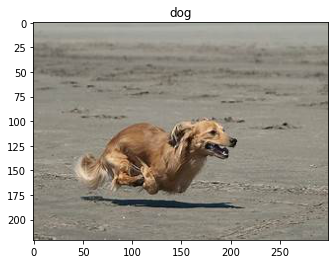

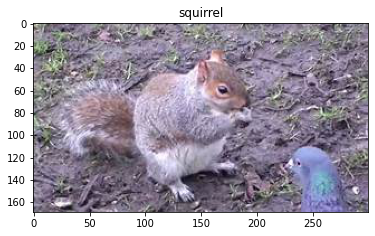

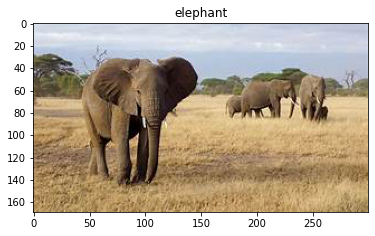

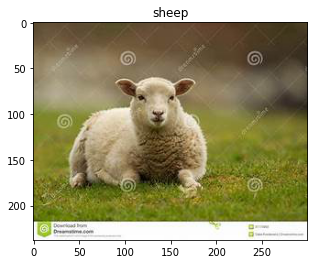

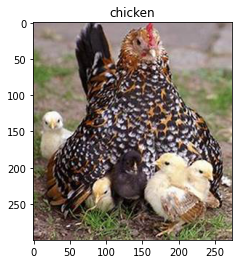

In [ ]:
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

Dapat dilihat ukuran gambar bervariasi

#Data Prepraration

###Split Folder: Train and Validation Folder

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder = base_dir

splitfolders.ratio(
    input_folder,
    output= "/content/animals10/dataset",
    seed=9,
    ratio=(0.8, 0.2),
    move=True,
    group_prefix=None
)
print("Moving files finished.")

os.listdir(input_folder)

for i in os.listdir(input_folder):
    if len(os.listdir(input_folder+"/"+ i)) == 0:
        os.rmdir(input_folder+"/"+ i)
print("Empty folders deleted.")

Copying files: 26179 files [00:02, 11626.27 files/s]

Moving files finished.
Empty folders deleted.


In [ ]:
train_dir = "/content/animals10/dataset/train"
valid_dir = "/content/animals10/dataset/val"

#Data Augmentation

In [ ]:
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (IMAGE_SIZE[0],IMAGE_SIZE[0],3)
BATCH_SIZE = 32
SEED = 999

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale = (1./255)
    )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = (1./255)
    )

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=(IMAGE_SIZE[0],IMAGE_SIZE[0]),
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    class_mode='categorical',
    target_size=(IMAGE_SIZE[0],IMAGE_SIZE[0]),
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


#Callback Function

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(epoch > 10):
      if(logs.get('accuracy')> 0.95 and logs.get('val_accuracy') > 0.95 ):
        print("\nTrain Accruracy and Validation Accuracy Was Reach > 95%!")
        self.model.stop_training = True
callbacks = myCallback()

#Accuracy Plot Function

In [ ]:
def acc_loss_plot(acc, val_acc, loss, val_loss):
  fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
  sns.set_style("darkgrid")

  ax[0].plot(acc, 'o-',label = 'Training accuracy')
  ax[0].plot(val_acc, 'o-',label = 'Validation accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_title('Training Accuracy vs Epochs', fontsize = 17)
  ax[0].legend(loc='best')


  ax[1].plot(loss, 'o-',label = 'Training loss')
  ax[1].plot(val_loss, 'o-',label = 'Validation loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('loss')
  ax[1].set_title('Loss vs. Epochs', fontsize = 17)
  ax[1].legend(loc='best')
  sns.set_style("darkgrid")

#Model Design

Pada tahap ini, akan dilakukan beberapa pemodelan untuk image classification, diantaranya adalah CNN(manual create) dan transfer learning.
Transfer Learning yang akan dicoba: Xception, VGG16, Resnet50V2, InceptionV3, DenseNet201, EfficientNetV2S


##1.CNN

###Model

In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=['accuracy']
  )

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

###CNN Train

In [ ]:
model1_hist = model1.fit(
    train_data,
    epochs=25,
    validation_data=valid_data,
    callbacks=[callbacks]
    )

Epoch 1/25
655/655 [==============================] - 104s 140ms/step - loss: 1.9656 - accuracy: 0.3110 - val_loss: 1.6470 - val_accuracy: 0.4306
Epoch 2/25
655/655 [==============================] - 83s 126ms/step - loss: 1.5211 - accuracy: 0.4800 - val_loss: 1.3512 - val_accuracy: 0.5388
Epoch 3/25
655/655 [==============================] - 83s 126ms/step - loss: 1.2548 - accuracy: 0.5765 - val_loss: 1.1127 - val_accuracy: 0.6344
Epoch 4/25
655/655 [==============================] - 83s 127ms/step - loss: 1.0859 - accuracy: 0.6362 - val_loss: 0.9550 - val_accuracy: 0.6835
Epoch 5/25
655/655 [==============================] - 82s 125ms/step - loss: 0.9709 - accuracy: 0.6753 - val_loss: 0.9104 - val_accuracy: 0.6991
Epoch 6/25
655/655 [==============================] - 83s 127ms/step - loss: 0.8757 - accuracy: 0.7050 - val_loss: 0.8289 - val_accuracy: 0.7197
Epoch 7/25
655/655 [==============================] - 83s 127ms/step - loss: 0.7938 - accuracy: 0.7335 - val_loss: 0.8040 - val_a

###Model Evaluate

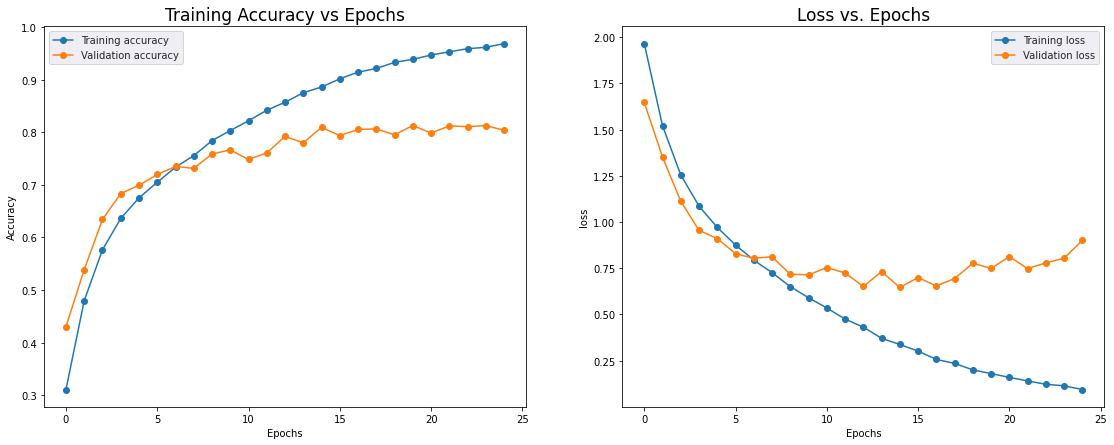

In [ ]:
acc = model1_hist.history['accuracy']
val_acc = model1_hist.history['val_accuracy']
loss = model1_hist.history['loss']
val_loss = model1_hist.history['val_loss']

acc_loss_plot(acc, val_acc, loss, val_loss)

##2.Xception

###Model

In [ ]:
base_model2 = tf.keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SHAPE)

base_model2.trainable = False

train_data.preprocessing_function = tf.keras.applications.xception.preprocess_input

model2 = tf.keras.models.Sequential([
    base_model2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])

model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=['accuracy']
  )

base_model2.summary()
model2.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

###Xception Train

In [ ]:
model2_hist = model2.fit(
    train_data,
    epochs=25,
    validation_data=valid_data,
    callbacks=[callbacks]
    )

Epoch 1/25
655/655 [==============================] - 135s 201ms/step - loss: 0.6729 - accuracy: 0.9177 - val_loss: 0.1686 - val_accuracy: 0.9550
Epoch 2/25
655/655 [==============================] - 128s 196ms/step - loss: 0.2093 - accuracy: 0.9422 - val_loss: 0.1602 - val_accuracy: 0.9578
Epoch 3/25
655/655 [==============================] - 129s 196ms/step - loss: 0.1905 - accuracy: 0.9510 - val_loss: 0.1520 - val_accuracy: 0.9569
Epoch 4/25
655/655 [==============================] - 129s 196ms/step - loss: 0.1608 - accuracy: 0.9551 - val_loss: 0.1481 - val_accuracy: 0.9597
Epoch 5/25
655/655 [==============================] - 129s 196ms/step - loss: 0.1447 - accuracy: 0.9601 - val_loss: 0.1648 - val_accuracy: 0.9613
Epoch 6/25
655/655 [==============================] - 128s 196ms/step - loss: 0.1310 - accuracy: 0.9634 - val_loss: 0.1562 - val_accuracy: 0.9620
Epoch 7/25
655/655 [==============================] - 128s 196ms/step - loss: 0.1235 - accuracy: 0.9668 - val_loss: 0.1711 -

###Model Evaluate

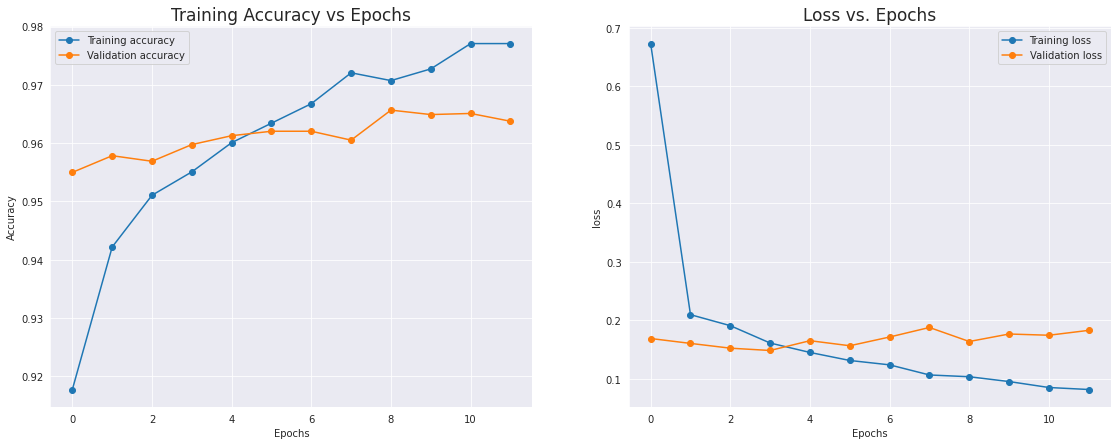

In [ ]:
acc = model2_hist.history['accuracy']
val_acc = model2_hist.history['val_accuracy']
loss = model2_hist.history['loss']
val_loss = model2_hist.history['val_loss']

acc_loss_plot(acc, val_acc, loss, val_loss)

##3.VGG16

###Model

In [ ]:
base_model3 = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SHAPE)

base_model3.trainable = False

train_data.preprocessing_function = tf.keras.applications.vgg16.preprocess_input

model3 = tf.keras.models.Sequential([
    base_model3,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])

model3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=['accuracy']
  )

base_model3.summary()
model3.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

### VGG16 Train

In [ ]:
model3_hist = model3.fit(
    train_data,
    epochs=25,
    validation_data=valid_data,
    callbacks=[callbacks]
    )

Epoch 1/25
655/655 [==============================] - 152s 227ms/step - loss: 1.1319 - accuracy: 0.6483 - val_loss: 0.6229 - val_accuracy: 0.8065
Epoch 2/25
655/655 [==============================] - 144s 220ms/step - loss: 0.7233 - accuracy: 0.7620 - val_loss: 0.5246 - val_accuracy: 0.8256
Epoch 3/25
655/655 [==============================] - 144s 220ms/step - loss: 0.6291 - accuracy: 0.7920 - val_loss: 0.5140 - val_accuracy: 0.8327
Epoch 4/25
655/655 [==============================] - 145s 221ms/step - loss: 0.5664 - accuracy: 0.8125 - val_loss: 0.4562 - val_accuracy: 0.8483
Epoch 5/25
655/655 [==============================] - 144s 221ms/step - loss: 0.5228 - accuracy: 0.8270 - val_loss: 0.4467 - val_accuracy: 0.8563
Epoch 6/25
655/655 [==============================] - 144s 220ms/step - loss: 0.4907 - accuracy: 0.8355 - val_loss: 0.4319 - val_accuracy: 0.8544
Epoch 7/25
655/655 [==============================] - 144s 220ms/step - loss: 0.4520 - accuracy: 0.8516 - val_loss: 0.4242 -

###Model Evaluate

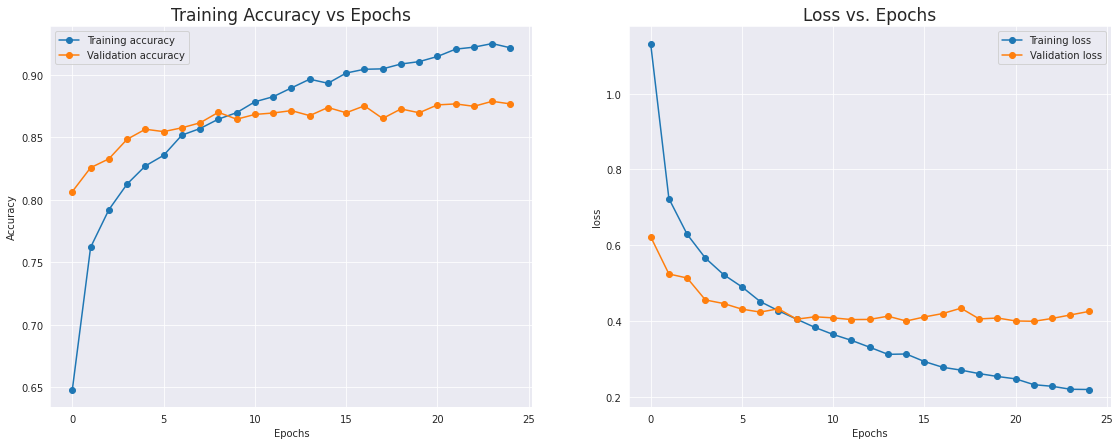

In [ ]:
acc = model3_hist.history['accuracy']
val_acc = model3_hist.history['val_accuracy']
loss = model3_hist.history['loss']
val_loss = model3_hist.history['val_loss']

acc_loss_plot(acc, val_acc, loss, val_loss)

##4.ResNet50V2

###Model

In [ ]:
base_model4 = tf.keras.applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SHAPE)

base_model4.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input

model4 = tf.keras.models.Sequential([
    base_model4,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])

model4.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=['accuracy']
  )

base_model4.summary()
model4.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

###ResNet50V2 Train

In [ ]:
model4_hist = model4.fit(
    train_data,
    epochs=25,
    validation_data=valid_data,
    callbacks=[callbacks]
    )

Epoch 1/25
655/655 [==============================] - 98s 143ms/step - loss: 1.0803 - accuracy: 0.8940 - val_loss: 0.2356 - val_accuracy: 0.9389
Epoch 2/25
655/655 [==============================] - 91s 139ms/step - loss: 0.2548 - accuracy: 0.9352 - val_loss: 0.2205 - val_accuracy: 0.9466
Epoch 3/25
655/655 [==============================] - 91s 140ms/step - loss: 0.2153 - accuracy: 0.9455 - val_loss: 0.2427 - val_accuracy: 0.9483
Epoch 4/25
655/655 [==============================] - 91s 139ms/step - loss: 0.1894 - accuracy: 0.9511 - val_loss: 0.2304 - val_accuracy: 0.9492
Epoch 5/25
655/655 [==============================] - 91s 140ms/step - loss: 0.1498 - accuracy: 0.9600 - val_loss: 0.2508 - val_accuracy: 0.9531
Epoch 6/25
655/655 [==============================] - 91s 139ms/step - loss: 0.1382 - accuracy: 0.9644 - val_loss: 0.2525 - val_accuracy: 0.9513
Epoch 7/25
655/655 [==============================] - 91s 139ms/step - loss: 0.1180 - accuracy: 0.9695 - val_loss: 0.2703 - val_ac

###Model Evaluate

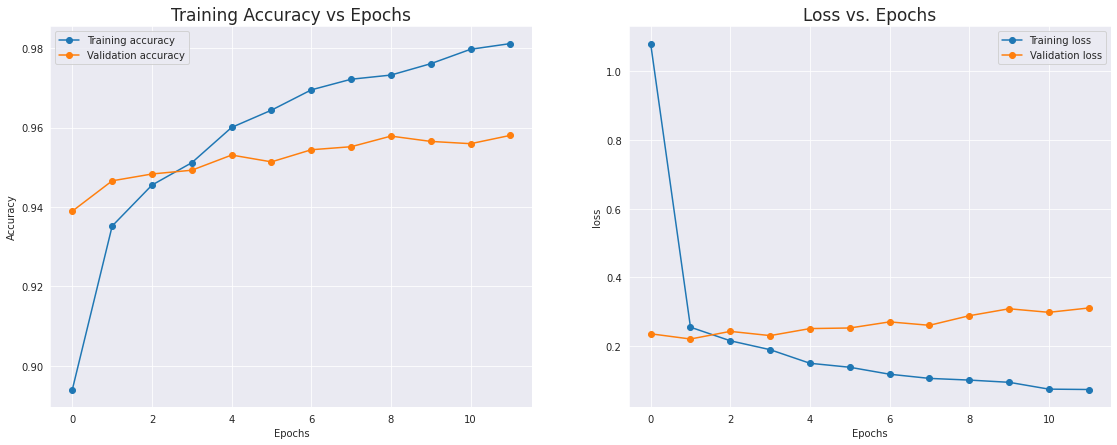

In [ ]:
acc = model4_hist.history['accuracy']
val_acc = model4_hist.history['val_accuracy']
loss = model4_hist.history['loss']
val_loss = model4_hist.history['val_loss']

acc_loss_plot(acc, val_acc, loss, val_loss)

##5.InceptionV3

###Model

In [ ]:
base_model5 = tf.keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SHAPE)

base_model5.trainable = False

train_data.preprocessing_function = tf.keras.applications.inception_v3.preprocess_input

model5 = tf.keras.models.Sequential([
    base_model5,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])

model5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=['accuracy']
  )

base_model5.summary()
model5.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d_9[0][0]']               
 rmalization)         

###InceptionV3 Train

In [ ]:
model5_hist = model5.fit(
    train_data,
    epochs=25,
    validation_data=valid_data,
    callbacks=[callbacks]
    )

Epoch 1/25
655/655 [==============================] - 96s 138ms/step - loss: 0.8374 - accuracy: 0.8996 - val_loss: 0.2020 - val_accuracy: 0.9416
Epoch 2/25
655/655 [==============================] - 85s 130ms/step - loss: 0.2427 - accuracy: 0.9319 - val_loss: 0.1916 - val_accuracy: 0.9510
Epoch 3/25
655/655 [==============================] - 86s 132ms/step - loss: 0.2088 - accuracy: 0.9440 - val_loss: 0.1610 - val_accuracy: 0.9565
Epoch 4/25
655/655 [==============================] - 86s 131ms/step - loss: 0.1853 - accuracy: 0.9467 - val_loss: 0.2114 - val_accuracy: 0.9489
Epoch 5/25
655/655 [==============================] - 87s 132ms/step - loss: 0.1699 - accuracy: 0.9509 - val_loss: 0.1667 - val_accuracy: 0.9590
Epoch 6/25
655/655 [==============================] - 86s 131ms/step - loss: 0.1564 - accuracy: 0.9550 - val_loss: 0.1867 - val_accuracy: 0.9554
Epoch 7/25
655/655 [==============================] - 85s 130ms/step - loss: 0.1374 - accuracy: 0.9603 - val_loss: 0.2249 - val_ac

###Model Evaluate

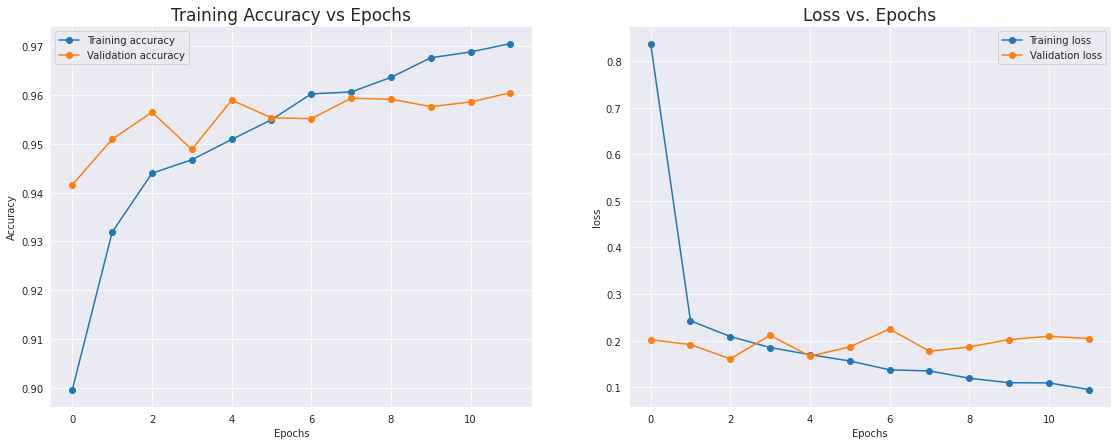

In [ ]:
acc = model5_hist.history['accuracy']
val_acc = model5_hist.history['val_accuracy']
loss = model5_hist.history['loss']
val_loss = model5_hist.history['val_loss']

acc_loss_plot(acc, val_acc, loss, val_loss)

##6.DenseNet201

###Model

In [ ]:
base_model6 = tf.keras.applications.DenseNet201(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SHAPE)

base_model6.trainable = False

train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

model6 = tf.keras.models.Sequential([
    base_model6,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])

model6.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=['accuracy']
  )

base_model6.summary()
model6.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

###DenseNet201 Train

In [ ]:
model6_hist = model6.fit(
    train_data,
    epochs=25,
    validation_data=valid_data,
    callbacks=[callbacks]
    )

Epoch 1/25
655/655 [==============================] - 158s 221ms/step - loss: 0.7765 - accuracy: 0.9099 - val_loss: 0.1684 - val_accuracy: 0.9561
Epoch 2/25
655/655 [==============================] - 137s 210ms/step - loss: 0.1976 - accuracy: 0.9443 - val_loss: 0.1517 - val_accuracy: 0.9605
Epoch 3/25
655/655 [==============================] - 137s 209ms/step - loss: 0.1673 - accuracy: 0.9544 - val_loss: 0.1566 - val_accuracy: 0.9578
Epoch 4/25
655/655 [==============================] - 137s 209ms/step - loss: 0.1354 - accuracy: 0.9611 - val_loss: 0.1722 - val_accuracy: 0.9618
Epoch 5/25
655/655 [==============================] - 137s 209ms/step - loss: 0.1318 - accuracy: 0.9626 - val_loss: 0.1552 - val_accuracy: 0.9609
Epoch 6/25
655/655 [==============================] - 137s 210ms/step - loss: 0.1126 - accuracy: 0.9680 - val_loss: 0.1504 - val_accuracy: 0.9636
Epoch 7/25
655/655 [==============================] - 137s 209ms/step - loss: 0.0913 - accuracy: 0.9729 - val_loss: 0.1625 -

###Model Evaluate

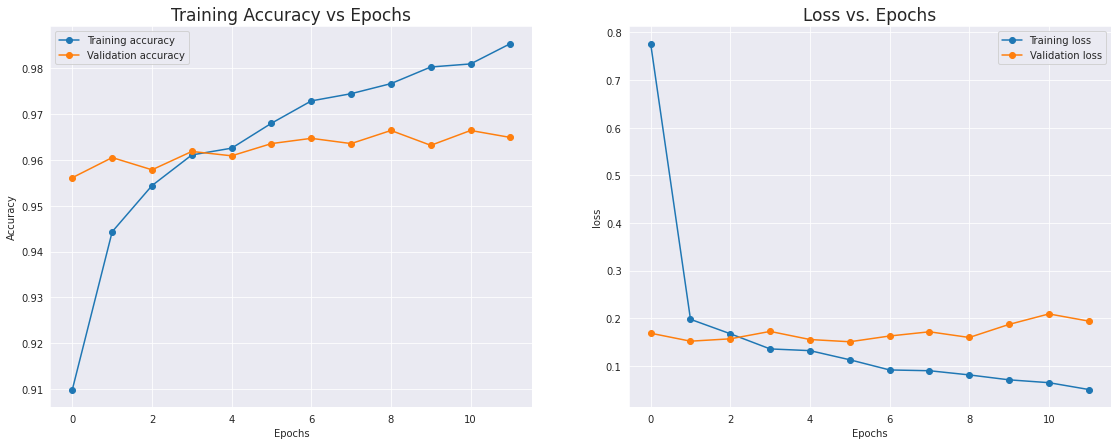

In [ ]:
acc = model6_hist.history['accuracy']
val_acc = model6_hist.history['val_accuracy']
loss = model6_hist.history['loss']
val_loss = model6_hist.history['val_loss']

acc_loss_plot(acc, val_acc, loss, val_loss)

##7.EfficienNetV2S

###Model

In [ ]:
base_model7 = tf.keras.applications.EfficientNetV2S(
    weights="imagenet",
    include_top=False,
    include_preprocessing = False,
    input_shape=IMAGE_SHAPE)

base_model7.trainable = False

train_data.preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input

model7 = tf.keras.models.Sequential([
    base_model7,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation='softmax')
])

model7.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=['accuracy']
  )

base_model7.summary()
model7.summary()

82420632/82420632 [==============================] - 1s 0us/step
Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 24  96          ['stem_conv[0][0]']              
                  

###EfficientNetV2S Train

In [ ]:
model7_hist = model7.fit(
    train_data,
    epochs=25,
    validation_data=valid_data,
    callbacks=[callbacks]
    )

Epoch 1/25
655/655 [==============================] - 138s 191ms/step - loss: 0.4386 - accuracy: 0.9348 - val_loss: 0.1295 - val_accuracy: 0.9727
Epoch 2/25
655/655 [==============================] - 121s 184ms/step - loss: 0.1698 - accuracy: 0.9605 - val_loss: 0.1461 - val_accuracy: 0.9727
Epoch 3/25
655/655 [==============================] - 121s 185ms/step - loss: 0.1390 - accuracy: 0.9661 - val_loss: 0.1360 - val_accuracy: 0.9752
Epoch 4/25
655/655 [==============================] - 121s 185ms/step - loss: 0.1192 - accuracy: 0.9696 - val_loss: 0.1399 - val_accuracy: 0.9748
Epoch 5/25
655/655 [==============================] - 121s 185ms/step - loss: 0.1072 - accuracy: 0.9715 - val_loss: 0.1266 - val_accuracy: 0.9767
Epoch 6/25
655/655 [==============================] - 121s 184ms/step - loss: 0.0898 - accuracy: 0.9789 - val_loss: 0.1239 - val_accuracy: 0.9752
Epoch 7/25
655/655 [==============================] - 121s 185ms/step - loss: 0.0896 - accuracy: 0.9769 - val_loss: 0.1397 -

###Model Evaluate

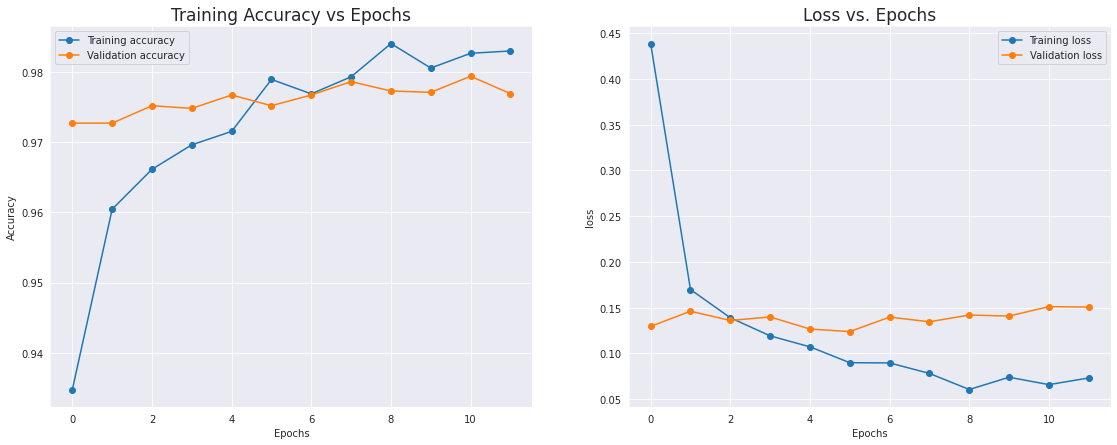

In [ ]:
acc = model7_hist.history['accuracy']
val_acc = model7_hist.history['val_accuracy']
loss = model7_hist.history['loss']
val_loss = model7_hist.history['val_loss']

acc_loss_plot(acc, val_acc, loss, val_loss)

#Evaluasi Semua Model

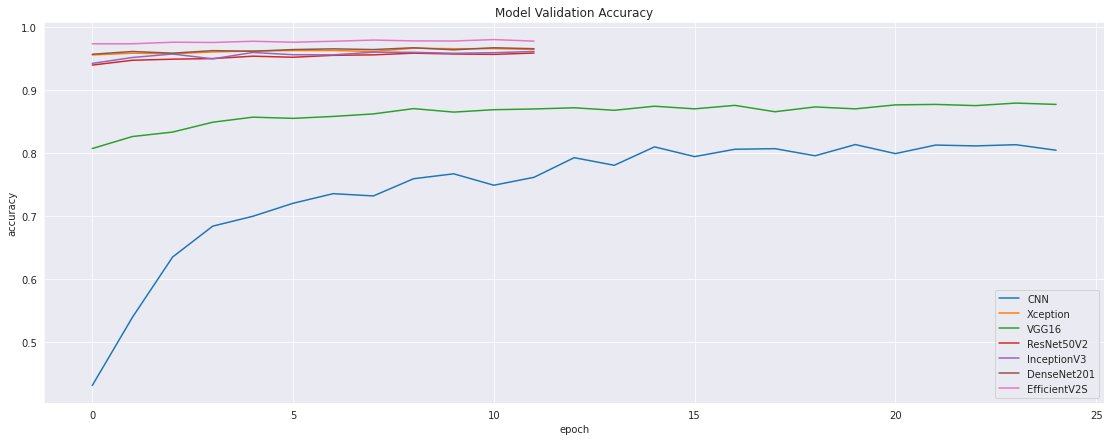

In [ ]:
plt.figure(figsize=(19,7))
plt.plot(model1_hist.history['val_accuracy'])
plt.plot(model2_hist.history['val_accuracy'])
plt.plot(model3_hist.history['val_accuracy'])
plt.plot(model4_hist.history['val_accuracy'])
plt.plot(model5_hist.history['val_accuracy'])
plt.plot(model6_hist.history['val_accuracy'])
plt.plot(model7_hist.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'Xception','VGG16', 'ResNet50V2', 'InceptionV3', 'DenseNet201', 'EfficientV2S'], loc='best')
plt.grid(True)
plt.show()

dapat dilihat bahwa model cnn dan vgg16 yang diuji memiliki akurasi train dan validasi <90%

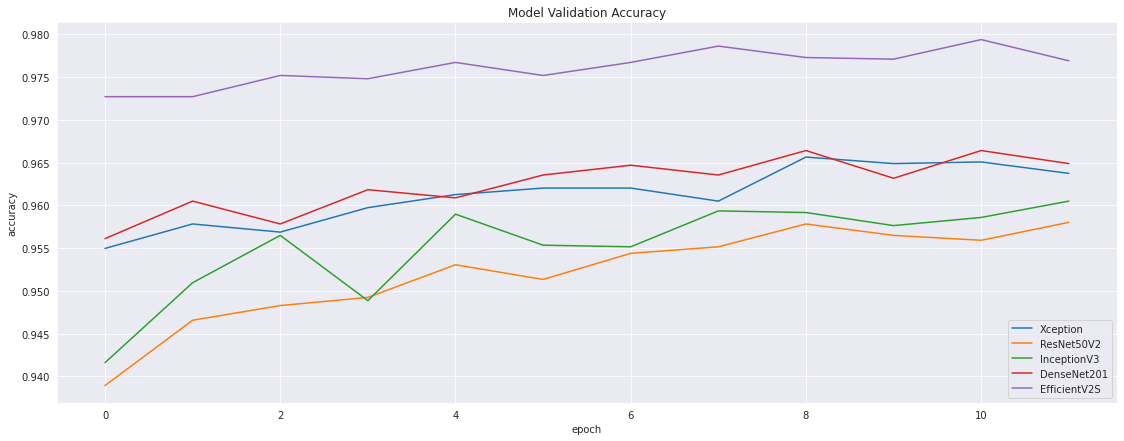

In [ ]:
plt.figure(figsize=(19,7))
plt.plot(model2_hist.history['val_accuracy'])
plt.plot(model4_hist.history['val_accuracy'])
plt.plot(model5_hist.history['val_accuracy'])
plt.plot(model6_hist.history['val_accuracy'])
plt.plot(model7_hist.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Xception', 'ResNet50V2', 'InceptionV3', 'DenseNet201', 'EfficientV2S'], loc='best')
plt.grid(True)
plt.show()

Dari Grafik dapat diketahui bahwa EfficienNetV2S memiliki validasi data terbaik daripada model lainnya, tetapi model ini tidak memiliki layers maxpooling2d(untuk submission), oleh sebab itu model ini tidak dipilih untuk submission. sebagai alternatif lainnya, pada submission ini akan dipakai model best (dengan conv2d dan maxpooling) yaitu InceptionNetV3, dengan ukuran parameter yang lebih kecil(~48M)

In [ ]:
best_model = model5

In [ ]:
loss_acc = best_model.evaluate(valid_data)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(loss_acc[0],loss_acc[1]))

164/164 [==============================] - 16s 97ms/step - loss: 0.2045 - accuracy: 0.9605
Test set
  Loss: 0.204
  Accuracy: 0.961


#Model Predict: The best one

In [ ]:
 kelas = train_data.class_indices
 kelas

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

In [ ]:
key_list = list(kelas.keys())
key_list

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

Saving tupai.jpg to tupai.jpg
1/1 [==============================] - 0s 31ms/step
squirrel


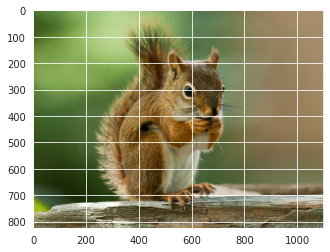

In [ ]:
from PIL import Image
from skimage import transform
from google.colab import files

def load(filename):
  np_image = Image.open(filename)
  plt.imshow(np_image)
  np_image = np.array(np_image).astype('float32')/255
  np_image = transform.resize(np_image, (224, 224, 3))
  np_image = np.expand_dims(np_image, axis=0)
  return np_image

uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  image = load(path)
  classes = best_model.predict(image)
  classes = np.argmax(classes)
  print(key_list[classes])



#Deployment

HDF5

In [ ]:
best_model.save('animals-recognition.hdf5')

TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('animals-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

#Penutup


Pada bebrpaa percobaan memodelkan arsitektur yang sesuai untuk mengklasifikasikan dataset animal10, 7 model yang dibuat telah berhasil. Model CNN yang didesain manual memiliki tingkat prediksi hingga ~80%, VGG16 87.6 %, Xception 96.3%, ResNet50V2 95.8%,  Inception 96%, DenseNet201 96% dan EfficientNetV2S 97.69%.

untuk model yang dipilih untuk ditransfer ke TFLite adalah InceptionV3 dengan footprint jumlah parameter yang lebih kecil (48M) dengan persentase prediksi 96%